In [ ]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics
from cosmosis.model import GPT

from dataset import TinyShakes

In [2]:
# explore the ds

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': 10,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   502]), 'position': tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}
torch.Size([10]) torch.int64
torch.Size([10]) torch.int64
decoded tokens:  First Citizen: Before we proceed any further, hear
decoded y:   Citizen: Before we proceed any further, hear me


In [3]:
# example using prompt for inference

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'prompt': 'First Citizen: Before we proceed any further, hear '}

prompt = TinyShakes(**ds_param)
print(prompt[0])
print(prompt[0]['tokens'].shape)
# y wont be used in inference but is generated automatically 
# as part of the reuse of the getitem machinery
print(prompt[0]['y'].shape) 
print('decoded tokens: ', prompt.encoding.decode(prompt[0]['tokens'].tolist()))
print('decoded y: ', prompt.encoding.decode(prompt[0]['y'].tolist()))

len(self.ds_idx):  1
data.nbytes:  22
CDataset created...
{'tokens': tensor([ 5962, 22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,
          220]), 'y': tensor([22307,    25,  7413,   356,  5120,   597,  2252,    11,  3285,   220]), 'position': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}
torch.Size([11])
torch.Size([10])
decoded tokens:  First Citizen: Before we proceed any further, hear 
decoded y:   Citizen: Before we proceed any further, hear 


In [4]:
# pass a single example from dataset to model to loss function
# (batch, d_seq, d_model)

d_seq = 3 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 4 # dimension embedding vector
d_model = 4 # dimension model input

assert d_model == d_vec

ds_param = {'transforms': {'tokens': [AsTensor()],
                           'y': [AsTensor()],
                           'position': [AsTensor()]},
            'd_seq': d_seq,
            'n': 5}

ts = TinyShakes(**ds_param)

print(ts[0])
print(ts[0]['tokens'].shape, ts[0]['tokens'].dtype)
print(ts[0]['y'].shape, ts[0]['y'].dtype)
print('decoded tokens: ', ts.encoding.decode(ts[0]['tokens'].tolist()))
print('decoded y: ', ts.encoding.decode(ts[0]['y'].tolist()))

model_param = {'device': 'cpu',
               'd_model': d_model, # matches embedding dimension
               'd_vocab': d_vocab, 
               'n_head': 2, 
               'num_layers': 2,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 

gpt = GPT(model_param)

data = ts[0]
out = gpt(data)
print('output: ', out, out.shape, out.dtype)

prompt_tokens = data['tokens']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['y']
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_embeddings = out.squeeze()
print('generated_embeddings: ', generated_embeddings, generated_embeddings.shape, generated_embeddings.dtype)
print('decoded generated tokens: ', prompt.encoding.decode(generated_embeddings.argmax(dim=-1).tolist()))

cel_func = CrossEntropyLoss()
loss = cel_func(out, target_tokens)
print('loss: ', loss)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  5
data.nbytes:  602664
CDataset created...
{'tokens': tensor([ 5962, 22307,    25]), 'y': tensor([22307,    25,  7413]), 'position': tensor([0, 1, 2])}
torch.Size([3]) torch.int64
torch.Size([3]) torch.int64
decoded tokens:  First Citizen:
decoded y:   Citizen: Before
applying _init_weights...
GPT model loaded...
number of model parameters:  201220
output:  tensor([[ 0.0069,  0.0168,  0.0580,  ..., -0.0273,  0.0639, -0.0131],
        [-0.0019,  0.0078,  0.0237,  ..., -0.0403,  0.0652,  0.0063],
        [-0.0422,  0.0211,  0.0521,  ..., -0.0379,  0.0138, -0.0096]],
       grad_fn=<MmBackward0>) torch.Size([3, 50304]) torch.float32
prompt_tokens:  tensor([ 5962, 22307,    25]) torch.Size([3]) torch.int64
target_tokens:  tensor([22307,    25,  7413]) torch.Size([3]) torch.int64
generated_embeddings:  tensor([[ 0.0069,  0.0168,  0.0580,  ..., -0.0273,  0.0

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyshakes_stripped_encoded.bin
len(self.ds_idx):  301232
data.nbytes:  602664
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
embedding weights failed to load.  reinitializing...
running model on gpu...

.....................

total elapsed time: 0:31:22.644390
epoch: 0
y_pred:   penet miscar foremost disarm lick sou exactmorrowiver celebrated prophetspected Greater CALaledkinsCA Seven prud piping reservationund recourse fortunes coupleoubted disob SAMTAGientASTER OF Hook Stephen cher withdraw fing shippingedlain chamber Sn demanded entered cow dearlyrays ic outcry breat Ad oddly fost nodd torctorsoks retreatutor late today GEasting shockCA Hus Cainitle pilgr combat partner littered miser must suggest Roy penet conveniently Present unsc Mam Dorliness Allow Barthgars Reggiving vul trained rejo proc restless rap late Thus THOUraw
y:   who comes her

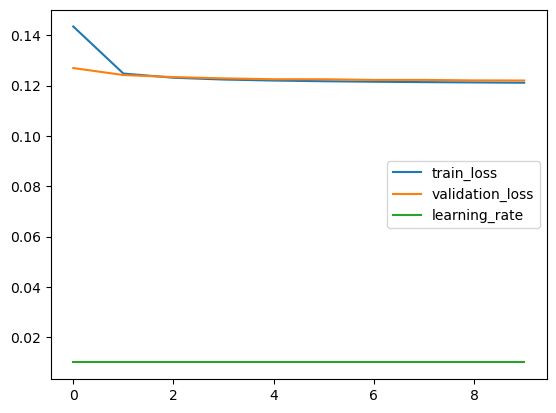

model: tinyshakes768 saved...


In [2]:
# put all together in a learner
# (batch, d_seq, d_model)

d_seq = 100 # dimension sequence
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
assert d_model == d_vec

ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                            'y': [AsTensor()],
                            'position': [AsTensor()]},
            'd_seq': d_seq,
            #'n': 1000,
                           }}

model_param = {'d_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_seq': d_seq,
               'd_vec': d_vec,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               'y': (d_vocab, d_vec, None, True),
                               'position': (d_seq, d_vec, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 1,
                 'log_plot': False,
                 'min_lr': .0025} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=32, epochs=10, gpu=True, save_model='tinyshakes768', 
              load_model=None, load_embed=True, target='y')

In [3]:
# inference
d_gen = 50 # dimension generate number of tokens
d_vocab = 50304 # dimension vocabulary
d_vec = 768 # dimension embedding vector
d_model = 768 # dimension model input
d_pos = 50 # dimension positional encoding d_pos >= max(len(prompt_tokens), d_gen)

assert d_model == d_vec


ds_param = {'train_param': {'transforms': {'tokens': [AsTensor()],
                                           'y': [AsTensor()],
                                           'position': [AsTensor()]},
                            'prompt': 'To be, or not to be, that is the question:'}
           }

model_param = {
               'd_model': d_model,
               'd_vocab': d_vocab, 
               'n_head': 12, 
               'num_layers': 12,
               'd_gen': d_gen,
               'd_vec': d_vec,
               'temperature': 100,
               'top_k': 1000,
               'embed_param': {'tokens': (d_vocab, d_vec, None, True), 
                               #'y': (d_vocab, d_vec, None, True),
                               'position': (d_pos, d_vec, None, True)},
              } 
                                       
metrics_param = {'metric_name': 'transformer'}                        
             
opt_param = {}

crit_param = {}

sample_param = {}

sched_param = {}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=None, 
              Scheduler=None, 
              Criterion=None, # no criterion implies inference
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=3, gpu=True, 
              load_model='tinyshakes768.pth', load_embed=True, target=None)


len(self.ds_idx):  1
data.nbytes:  26
CDataset created...
applying _init_weights...
GPT model loaded...
number of model parameters:  38634240
model loaded from state_dict...
loading embedding weights...
running model on gpu...

.....................

total learning time: 0:00:01.286960
predictions:  [[" Lam to and the, be not and tragic it d, I, to Theu,atsreedingives the of give Without,', come me of, you I safest dR: of tofor you Are,man 'run, is"]]
inference instance 2025-03-08 08:54:18.445852 complete and saved to csv...

.....................

total learning time: 0:00:01.370647
predictions:  [[" Lam to and the, the married and he it d, I, it a amen a,, not.,ing,'s Flor and heart text and queen ' thee'd offily; bruisedling his cause thou, to,:.''d"]]
inference instance 2025-03-08 08:54:18.529539 complete and saved to csv...

.....................

total learning time: 0:00:01.452474
predictions:  [["erd to andacle, the not and you it d, I:ician, toward your,,, knees himing him- sp